In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
from keras.datasets import mnist
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)
  return (X_train, y_train), (X_test, y_test)

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def preprocess_data(data):
  scaler = StandardScaler()
  data_std = scaler.fit_transform(data)
  n_components = 30
  pca = PCA(n_components=n_components)
  data_pca = pca.fit_transform(data_std)
  return data_pca

In [5]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [6]:
train_data_0 = pd.DataFrame(X_train[y_train == 0])
train_data_1 = pd.DataFrame(X_train[y_train == 1])[:3000]
#train_data_2 = pd.DataFrame(X_train[y_train == 2])
#train_data_3 = pd.DataFrame(X_train[y_train == 3])
train_data = pd.DataFrame(pd.concat([train_data_0,train_data_1]))
train = train_data.reset_index(drop = True)

train_label_0 = pd.DataFrame(y_train[y_train == 0])
train_label_1 = pd.DataFrame(y_train[y_train == 1])[:3000]
#train_label_2 = pd.DataFrame(y_train[y_train == 2])
#train_label_3 = pd.DataFrame(y_train[y_train == 3])
train_data_label = pd.DataFrame(pd.concat([train_label_0,train_label_1]))
y_train = train_data_label.reset_index(drop = True)

In [7]:
test_data_0 = pd.DataFrame(X_test[y_test.flatten() == 0])
test_data_1 = pd.DataFrame(X_test[y_test.flatten() == 1])[:500]
#test_data_2 = pd.DataFrame(X_test[y_test.flatten() == 2])
#test_data_3 = pd.DataFrame(X_test[y_test.flatten() == 3])
test_data = pd.DataFrame(pd.concat([test_data_0,test_data_1]))
test = test_data.reset_index(drop = True)

test_label_0 = pd.DataFrame(y_test[y_test == 0])
test_label_1 = pd.DataFrame(y_test[y_test == 1])[:500]
#test_label_2 = pd.DataFrame(y_test[y_test == 2])
#test_label_3 = pd.DataFrame(y_test[y_test == 3])
test_data_label = pd.DataFrame(pd.concat([test_label_0,test_label_1]))
y_test = test_data_label.reset_index(drop = True)

In [8]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [9]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

## **Expectation Step**

In [10]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_mb(row,alphas):
  log_mb = []
  for alpha in alphas:
    q = gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + np.sum((alpha-1)*np.log(row)) - np.sum((alpha+1)*np.log(1-row)) - np.sum(alpha)*np.log(1+np.sum(row/(1-row)))
    log_mb.append(q)
  return np.array(log_mb)

In [11]:
def expectation_step(data, alphas, P,number_of_clusters):
    Z = np.zeros((len(data), number_of_clusters))

    for i, row in enumerate(data):
        log_posteriors = np.log(P) + log_mb(row, alphas)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        Z[i] = posteriors / np.sum(posteriors)
    return Z

## **Maximization Step** ##

In [12]:
def update_P(Z):
  return np.mean(Z,axis=0)

In [13]:
def normalize_alpha(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [14]:
def calcul_inv_hess_vect(data,alpha,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-15),None)
  inv_hess_vect_matrices = []
  for j in range(M):
    alpha_j = alpha[j]
    S = np.diag([-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)])
    a_T = np.array([[-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)]])
    gamma_et = float(polygamma(1,np.sum(alpha_j)))*N*Z_mean[j] / (1+float(polygamma(1,np.sum(alpha_j)))*N*Z_mean[j]*np.sum([-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)]))
    H_inv = S + gamma_et*np.dot(a_T.T,a_T)
    inv_hess_vect_matrices.append(H_inv)
  return inv_hess_vect_matrices

In [15]:
def derivative(data,alpha_old,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.mean(Z,axis=0)
  der_param = []
  for j in range(M):
    der_vect_alpha_j = np.zeros(K)
    alpha_old_j = alpha_old[j]
    for s in range(K):
      der_vect_alpha_j[s] =N*Z_mean[j]*(psi(np.sum(alpha_old_j)) - psi(alpha_old_j[s])) + np.sum( Z[:,j]*np.log(data[:,s]) ) - np.sum( Z[:,j]*np.log(1-data[:,s]) ) - np.sum( Z[:,j]*np.log(1+np.sum(data[:,s]/(1-data[:,s]))) )
    der_param.append(der_vect_alpha_j)
  return der_param

In [16]:
def update_alpha(data,alpha_old,Z,number_of_clusters):
  M = number_of_clusters
  inv_hess = calcul_inv_hess_vect(data,alpha_old,Z,number_of_clusters)
  der_param = derivative(data,alpha_old,Z,number_of_clusters)
  alpha_new = []
  for j in range(M):
    (alpha_old_j,der_param_j,Hess_j) = (alpha_old[j],der_param[j],inv_hess[j])
    alpha_new_j = alpha_old_j - np.dot(Hess_j,der_param_j)
    alpha_new.append(np.array(normalize_alpha(np.array(alpha_new_j),0.1,3.5)))
  return alpha_new

In [17]:
#We tried several random initializations, and these values gave us the best results
alpha_zero = [np.array([0.52354723, 0.134941  , 1.01956433, 2.00210472, 2.65016962,
       3.1354354 , 0.86893963, 0.49199306, 3.11691198, 1.40914245,
       3.19138845, 2.99152405, 0.62372424, 0.92974962, 0.57186966,
       3.10785314, 1.04151591, 0.32587133, 0.50651452, 1.5578445 ,
       3.19148754, 2.00809334, 1.96126915, 3.20145573, 2.67862186,
       2.11381299, 0.77133638, 2.59008215, 1.81615581, 3.05074863]), np.array([1.75833134, 2.06563795, 3.19952211, 2.11451295, 1.54165584,
       1.04628818, 1.68954903, 0.77083663, 1.10372221, 1.16502352,
       3.10930102, 0.63007507, 0.60264953, 2.80297555, 0.79270307,
       0.19958296, 3.33407334, 0.68115006, 2.20941491, 2.96563126,
       1.25144854, 2.9965609 , 1.14809436, 0.38172431, 0.56126471,
       3.24948339, 2.49004164, 1.88973949, 0.17149445, 2.13878802])]

In [18]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

x_train_task = train
x_test_task = test

#EM Algorithm
M = 2
P = [0.9, 0.1]
alpha_old = alpha_zero
max_iter = 3
for iteration in range(max_iter):
  Z = expectation_step(x_train_task,alpha_old,P,M)
  alpha_new = update_alpha(x_train_task,alpha_old,Z,M)
  P = np.clip(update_P(Z),10**(-15),None)
  alpha_old = alpha_new

In [19]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

predictions_bin = []
for row in x_test_task:
      log_posteriors = np.exp(np.log(P)+log_mb(row,alpha_new))
      predicted_label = np.argmax(log_posteriors)
      predictions_bin.append(predicted_label)
predictions_bin = np.asarray(predictions_bin)
labels = np.array(y_test).flatten() == 0
f1 = f1_score(labels, predictions_bin)
precision = precision_score(labels, predictions_bin)
recall = recall_score(labels, predictions_bin)
acc = accuracy_score(labels, predictions_bin)

print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", acc)

F1 score: 0.8189300411522633
Precision: 0.8257261410788381
Recall: 0.8122448979591836
Accuracy: 0.7621621621621621


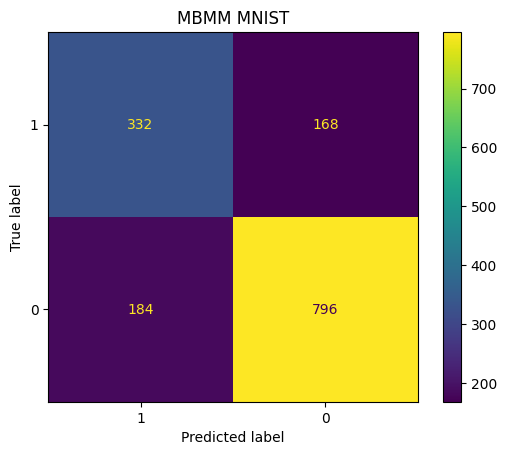

In [20]:
cm = confusion_matrix(labels, predictions_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1', '0'])
cm_display.plot()
cm_display.ax_.set_title('MBMM MNIST')
plt.show()